In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
import matplotlib.pyplot as plt
import numpy as np

### Menyiapkan Dataset

Dataset yang digunakan adalah `tf_flowers` dari `tensorflow_datasets` (±3.670 gambar, 5 kelas). Dataset dibagi menjadi 70% data latih, 15% data validasi, dan 15% data uji. Gambar disimpan ke folder lokal `flowers/train|validation|test` per kelas agar mudah dipakai oleh `ImageDataGenerator`. Jika gambar sudah ada, proses simpan akan dilewati.

In [2]:
import tensorflow_datasets as tfds
import os
import shutil
import glob
import random
from absl import logging as absl_logging

absl_logging.set_verbosity(absl_logging.ERROR)

TFDS_DIR = os.path.join(os.getcwd(), 'tfds_data')
os.makedirs(TFDS_DIR, exist_ok=True)

base_dir = os.path.join(os.getcwd(), 'flowers')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def has_images(path):
    for root, _, files in os.walk(path):
        if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in files):
            return True
    return False

def prepare_dirs(class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

def save_images_from_tfds(dataset, directory, class_names):
    for i, (image, label) in enumerate(dataset.as_numpy_iterator()):
        class_name = class_names[label]
        filename = f'image_{i}.jpg'
        filepath = os.path.join(directory, class_name, filename)
        if not os.path.exists(filepath):
            tf.keras.utils.save_img(filepath, image)

class_names = None
used_source = None

already_ready = has_images(train_dir) and has_images(validation_dir) and has_images(test_dir)

if already_ready:
    class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    used_source = 'existing'
else:
    try:
        (ds_train, ds_validation, ds_test), ds_info = tfds.load(
            'tf_flowers',
            split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
            with_info=True,
            as_supervised=True,
            data_dir=TFDS_DIR,
        )
        class_names = ds_info.features['label'].names
        prepare_dirs(class_names)
        save_images_from_tfds(ds_train, train_dir, class_names)
        save_images_from_tfds(ds_validation, validation_dir, class_names)
        save_images_from_tfds(ds_test, test_dir, class_names)
        used_source = 'tfds'
    except Exception as e:
        print(f"Gagal mengunduh via TFDS: {e.__class__.__name__}: {e}")
        candidates = [
            os.path.join('data', 'flower_photos'),
            os.path.join('local_data', 'flower_photos'),
            os.path.join(os.getcwd(), 'flower_photos'),
        ]
        src_dir = next((d for d in candidates if os.path.isdir(d)), None)
        if src_dir is None:
            raise RuntimeError(
                "Tidak dapat menyiapkan dataset. Aktifkan internet untuk TFDS atau letakkan folder 'flower_photos' di ./data/ atau ./local_data/ atau root repo."
            )
        class_names = sorted([d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))])
        prepare_dirs(class_names)
        random.seed(42)
        for cls in class_names:
            files = [f for f in glob.glob(os.path.join(src_dir, cls, '*')) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(files)
            n = len(files)
            n_train = int(0.7 * n)
            n_val = int(0.15 * n)
            train_files = files[:n_train]
            val_files = files[n_train:n_train + n_val]
            test_files = files[n_train + n_val:]
            for f in train_files:
                shutil.copy2(f, os.path.join(train_dir, cls, os.path.basename(f)))
            for f in val_files:
                shutil.copy2(f, os.path.join(validation_dir, cls, os.path.basename(f)))
            for f in test_files:
                shutil.copy2(f, os.path.join(test_dir, cls, os.path.basename(f)))
        used_source = 'local'

print(f"Dataset siap di 'flowers' (train/validation/test). Sumber: {used_source}.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/tfds_data/tf_flowers/incomplete.2XG9L1_3.0.1/tf_flowers-train.tfrecord*...:   0%|          …

Dataset tf_flowers downloaded and prepared to /content/tfds_data/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Dataset siap di 'flowers' (train/validation/test). Sumber: tfds.


### Augmentasi Gambar dan Generator Data

Kita akan menggunakan `ImageDataGenerator` untuk melakukan augmentasi gambar pada data latih (seperti rotasi, zoom, flip horizontal) untuk mencegah overfitting. Data validasi tidak akan diaugmentasi. Ukuran gambar akan diubah menjadi 150x150 piksel.

In [3]:
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=applications.mobilenet_v2.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2569 images belonging to 5 classes.
Found 551 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


### Membangun Model Jaringan Saraf Tiruan (CNN)

Model yang akan kita bangun adalah model sekuensial dengan beberapa lapisan konvolusi dan pooling. Arsitektur model ini terdiri dari:
- 3 lapis `Conv2D` dengan fungsi aktivasi `relu` dan `MaxPooling2D`.
- Sebuah lapis `Flatten` untuk mengubah matriks fitur menjadi vektor.
- Sebuah lapis `Dense` dengan 512 neuron dan fungsi aktivasi `relu`.
- Sebuah lapis `Dense` sebagai output dengan 5 neuron (sesuai jumlah kelas) dan fungsi aktivasi `softmax`.

Model akan di-compile dengan `optimizer='adam'`, `loss='categorical_crossentropy'`, dan `metrics=['accuracy']`.

In [4]:
USE_TRANSFER = True
IMG_SIZE = (224, 224)
NUM_CLASSES = 5

if USE_TRANSFER:
    base = applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    base.trainable = False
    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE + (3,)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Melatih Model

Kita akan melatih model dengan data generator yang sudah kita siapkan. Kita juga akan menggunakan `EarlyStopping` callback untuk menghentikan training jika akurasi pada validation set tidak meningkat setelah beberapa epoch. Ini akan membantu mencegah overfitting.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.6918 - loss: 0.8440 - val_accuracy: 0.8364 - val_loss: 0.4369 - learning_rate: 0.0010
Epoch 2/50
 1/80 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.8125 - loss: 0.3540

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 501ms/step - accuracy: 0.8125 - loss: 0.3540 - val_accuracy: 0.8364 - val_loss: 0.4237 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8755 - loss: 0.3455 - val_accuracy: 0.8640 - val_loss: 0.3734 - learning_rate: 0.0010
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 295ms/step - accuracy: 0.7812 - loss: 0.8126 - val_accuracy: 0.8750 - val_loss: 0.3520 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.8844 - loss: 0.3180 - val_accuracy: 0.8824 - val_loss: 0.3335 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 295ms/step - accuracy: 0.8750 - loss: 0.4760 - val_accuracy: 0.8842 - val_loss: 0.3351 - learning_rate: 0.0010
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9082 - loss: 0.2594 - val_accuracy: 0.8934 - val_loss: 0.3168 - learning_rate: 0.0010
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 287ms/step - accuracy: 0.9688 - loss: 0.1233 - val_accura

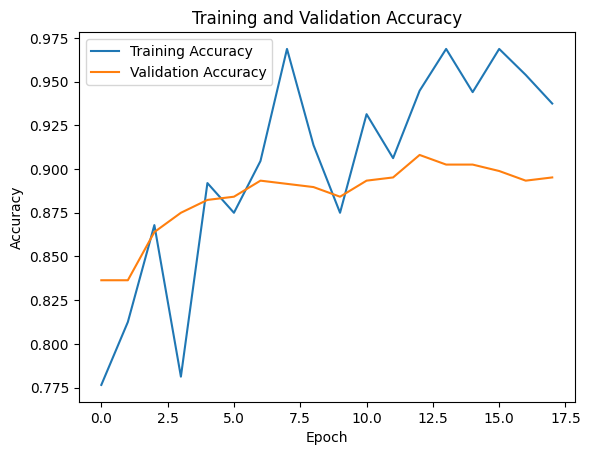

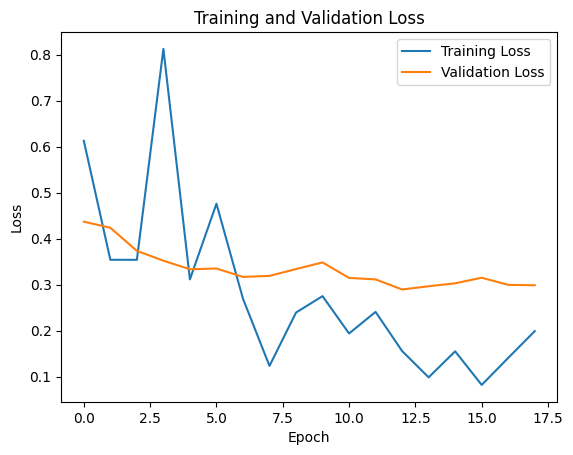

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import warnings

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=r"Your `PyDataset` class should call .*super\(\).__init__\(\*\*kwargs\)"
)

os.makedirs('checkpoints', exist_ok=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
ckpt = ModelCheckpoint('checkpoints/best.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, ckpt]
)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.8490 - loss: 0.4421 - val_accuracy: 0.8971 - val_loss: 0.3239 - learning_rate: 1.0000e-05
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 571ms/step - accuracy: 0.8438 - loss: 0.3687 - val_accuracy: 0.8971 - val_loss: 0.3241 - learning_rate: 1.0000e-05
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8976 - loss: 0.3204 - val_accuracy: 0.8971 - val_loss: 0.3159 - learning_rate: 1.0000e-05
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - accuracy: 0.9375 - loss: 0.1211 - val_accuracy: 0.8971 - val_loss: 0.3045 - learning_rate: 1.0000e-05
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.8959 - loss: 0.2797 - val_accuracy: 0.9026 - val_loss: 0.3207 - learning_rate: 1.0000e-05
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - accuracy: 0.9688 - loss: 0.1129 - val_accuracy: 0.9026 - val_loss: 0.3082 - learning_rate: 1.0000e-05
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0

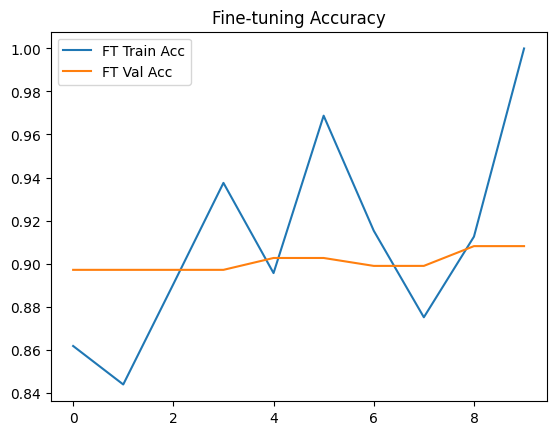

In [7]:
if USE_TRANSFER:
    base.trainable = True
    for layer in base.layers[:-30]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    fine_history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping, reduce_lr, ckpt]
    )

    plt.figure()
    plt.plot(fine_history.history['accuracy'], label='FT Train Acc')
    plt.plot(fine_history.history['val_accuracy'], label='FT Val Acc')
    plt.legend(); plt.title('Fine-tuning Accuracy'); plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9194 - loss: 0.2539
Test accuracy: 0.9173, Test loss: 0.2449
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


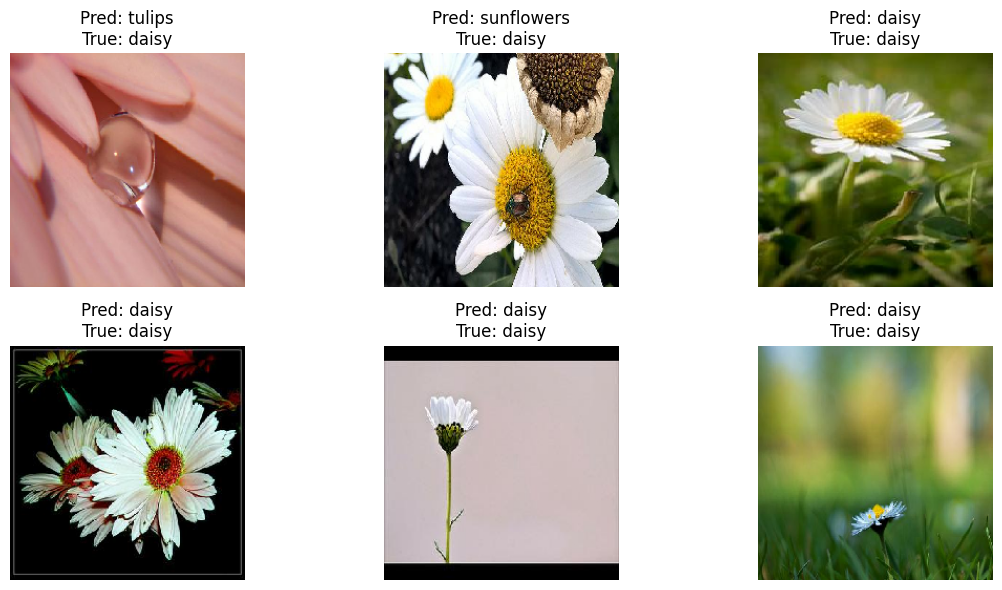

18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


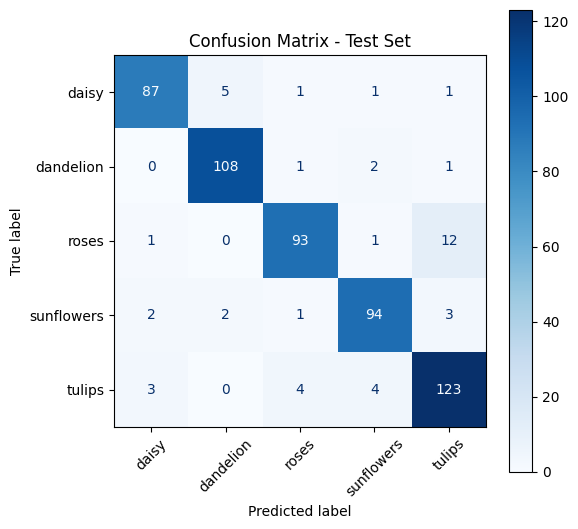

In [8]:
loss, acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {acc:.4f}, Test loss: {loss:.4f}")

batch_images, batch_labels = next(test_generator)
preds = model.predict(batch_images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(batch_labels, axis=1)
label_map = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    disp = batch_images[i]
    disp = (disp - disp.min()) / (disp.max() - disp.min() + 1e-8)
    plt.imshow(disp.astype('float32'))
    plt.axis('off')
    plt.title(f"Pred: {label_map[pred_classes[i]]}\nTrue: {label_map[true_classes[i]]}")
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_preds = model.predict(test_generator)
all_pred_classes = np.argmax(all_preds, axis=1)
cm = confusion_matrix(test_generator.classes, all_pred_classes)
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(cm, display_labels=list(label_map.values())).plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Test Set')
plt.show()

### Menyimpan Model

Setelah model dilatih, kita akan menyimpannya dalam tiga format yang berbeda:
- **SavedModel**: Format standar TensorFlow.
- **TFLite**: Format yang dioptimalkan untuk perangkat mobile.
- **TFJS**: Format untuk digunakan di lingkungan JavaScript (browser).

In [14]:
import os
import sys
import subprocess

try:
    import tensorflowjs as tfjs
except ModuleNotFoundError:
    try:
        print('Installing tensorflowjs...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tensorflowjs'])
        import tensorflowjs as tfjs
    except Exception as e:
        tfjs = None
        print(f"TensorFlow.js isn't available (install failed): {e}. Skipping TFJS export.")

os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('tfjs_model', exist_ok=True)

export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

def _configure_tflite_converter(converter):
    if hasattr(converter, 'experimental_enable_resource_variables'):
        converter.experimental_enable_resource_variables = True
    try:
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS,
        ]
    except Exception:
        pass
    if hasattr(converter, '_experimental_lower_tensor_list_ops'):
        try:
            converter._experimental_lower_tensor_list_ops = True
        except Exception:
            pass
    return converter

try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter = _configure_tflite_converter(converter)
    tflite_model = converter.convert()
    conv_source = 'keras_model'
except Exception as e:
    print(f'Primary TFLite conversion failed from Keras model: {e}\nRetrying from SavedModel...')
    converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
    converter = _configure_tflite_converter(converter)
    tflite_model = converter.convert()
    conv_source = 'saved_model'

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

class_names = sorted(train_generator.class_indices.keys())
with open('tflite/label.txt', 'w') as f:
    for name in class_names:
        f.write(f"{name}\n")

if 'tfjs' in globals() and tfjs is not None:
    try:
        tfjs.converters.save_keras_model(model, 'tfjs_model')
        print('TFJS model exported to tfjs_model/')
    except Exception as e:
        print(f'Failed to export TFJS: {e}')
else:
    print('Skipping TFJS export; tensorflowjs not installed.')

print(f'Model tersimpan: SavedModel, TFLite (from {conv_source})', '(+ TFJS)' if ('tfjs' in globals() and tfjs is not None) else '(TFJS skipped)')

Saved artifact at '/tmp/tmp_4zop15v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136775684673744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775684673360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775651101776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775652227984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775655880272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775684671632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775651101392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775651102928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775651102544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136775651102160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1367756511

In [15]:
import random

any_class = random.choice(os.listdir(test_dir))
class_dir = os.path.join(test_dir, any_class)
img_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
img_path = os.path.join(class_dir, random.choice(img_files))

img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = applications.mobilenet_v2.preprocess_input(x)

interpreter = tf.lite.Interpreter(model_path='tflite/model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inp = x.astype(input_details[0]['dtype'])
if tuple(input_details[0]['shape']) != tuple(inp.shape):
    interpreter.resize_tensor_input(input_details[0]['index'], list(inp.shape))
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], inp)

try:
    interpreter.invoke()
except Exception as e:
    raise RuntimeError(f"TFLite inference failed: {e}. Coba ekspor ulang TFLite dengan SELECT_TF_OPS (sudah diaktifkan) atau periksa versi TensorFlow.")

output = interpreter.get_tensor(output_details[0]['index'])
pred_idx = int(np.argmax(output, axis=1)[0])

label_map = {v: k for k, v in train_generator.class_indices.items()}
print(f"TFLite prediction for {os.path.basename(img_path)} -> {label_map[pred_idx]}")

TFLite prediction for image_516.jpg -> roses


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
